<a href="https://colab.research.google.com/github/alessandrossC/bank_deposit/blob/main/01_bestmodel_bank_deposit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting Client Subscription to Term Deposit

The goal is to predict whether a client will subscribe to a term deposit (y: yes/no), which is a binary classification problem.

Several machine learning methods are suitable for this task:

Logistic Regression is a simple and interpretable baseline model. It works well when the relationship between features and the target variable is approximately linear.

Random Forest and XGBoost are powerful ensemble methods that perform well in capturing complex, nonlinear relationships and feature interactions.

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import sys
sys.path.append('/content')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
!wget -O process_bank https://raw.githubusercontent.com/alessandrossC/bank_deposit/main/process_bank.py

--2025-06-13 07:50:39--  https://raw.githubusercontent.com/alessandrossC/bank_deposit/main/process_bank.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9622 (9.4K) [text/plain]
Saving to: ‘process_bank’

process_bank        100%[===================>]   9.40K  --.-KB/s    in 0.001s  

2025-06-13 07:50:39 (15.8 MB/s) - ‘process_bank’ saved [9622/9622]



In [33]:
import sys
sys.path.append(".")
from process_bank import (split_data, create_inputs_and_targets,
                                  get_auc, get_eval_results, get_confusion_matrix)

In [17]:
raw_data = pd.read_csv('/content/bank_data.csv')
raw_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,cons.price.idx_diff,default_grouped,y_numeric
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,no,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,not_no,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,no,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,no,0


In [50]:
split_dict = split_data(raw_data, 'y')
print(split_dict.keys())                     # dict_keys(['train', 'test'])
print(split_dict['train'].shape)
print(split_dict['test'].shape)

dict_keys(['train', 'test'])
(32940, 23)
(8236, 23)


In [51]:
input_cols = list(raw_data.drop(columns=['duration', 'y']).columns)
target_col = 'y'

In [52]:
data_dict = create_inputs_and_targets(split_dict, input_cols, target_col)
print(data_dict.keys())                      # dict_keys([...inputs..., ...targets...])
print(data_dict['train_inputs'].shape)
print(data_dict['train_targets'].value_counts())

dict_keys(['train_inputs', 'train_targets', 'test_inputs', 'test_targets'])
(32940, 22)
y
0    29229
1     3711
Name: count, dtype: int64


In [53]:
train_inputs, train_targets = data_dict['train_inputs'], data_dict['train_targets']
test_inputs, test_targets = data_dict['test_inputs'], data_dict['test_targets']

In [54]:
print(train_inputs.shape)
print(train_targets.value_counts())
print(test_inputs.shape)
print(test_targets.value_counts())

(32940, 22)
y
0    29229
1     3711
Name: count, dtype: int64
(8236, 22)
y
0    7308
1     928
Name: count, dtype: int64


In [56]:
#Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include='number').columns.to_list()
categorical_cols = train_inputs.select_dtypes(include='object').columns.to_list()

In [57]:
print(train_inputs[numeric_cols].describe())
print(train_inputs[categorical_cols].nunique())

                age      campaign         pdays      previous  emp.var.rate  \
count  32940.000000  32940.000000  32940.000000  32940.000000  32940.000000   
mean      40.017122      2.561961    962.617243      0.173801      0.080134   
std       10.453345      2.769972    186.555316      0.498578      1.571503   
min       17.000000      1.000000      0.000000      0.000000     -3.400000   
25%       32.000000      1.000000    999.000000      0.000000     -1.800000   
50%       38.000000      2.000000    999.000000      0.000000      1.100000   
75%       47.000000      3.000000    999.000000      0.000000      1.400000   
max       98.000000     56.000000    999.000000      7.000000      1.400000   

       cons.price.idx  cons.conf.idx     euribor3m   nr.employed  \
count    32940.000000   32940.000000  32940.000000  32940.000000   
mean        93.575607     -40.509824      3.618053   5166.905950   
std          0.579469       4.629072      1.735931     72.397892   
min         92.2

## Preprocessing

In [58]:
#Scaling of the numeric columns
scaler = MinMaxScaler()
numerical_transformer = Pipeline(steps=[
    ('scaler', scaler)
])

In [59]:
#Encoding of the categorical columns
encoder = OneHotEncoder(
    sparse_output=False, handle_unknown='ignore'
)

categorical_transformer = Pipeline(steps=[
    ('onehot_enc', encoder)
])

In [62]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])


## LogisticRegression

In [80]:
# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
], remainder='passthrough',
verbose_feature_names_out=False)

preprocessor.set_output(transform='pandas')

clf = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

shuffled_targets = np.random.permutation(train_targets)

get_auc(model_pipeline, train_inputs, shuffled_targets)

AUROC score on train set:: 0.534
AUROC score on validation set:: 0.494


(np.float64(0.5338188963779534), np.float64(0.49395442389761796))

In [81]:
for col in train_inputs.columns:
    print(col, train_inputs[col].nunique())

age 77
job 12
marital 4
education 8
default 2
housing 3
loan 3
contact 2
month 10
day_of_week 5
campaign 41
pdays 27
previous 8
poutcome 3
emp.var.rate 10
cons.price.idx 26
cons.conf.idx 26
euribor3m 312
nr.employed 11
cons.price.idx_diff 26
default_grouped 2


In [82]:
df_debug = train_inputs.copy()
df_debug['target'] = train_targets.values
print(df_debug.head())

       age            job  marital            education default housing loan  \
36444   24     technician   single  professional.course      no      no   no   
1233    32    blue-collar  married  professional.course      no      no   no   
24104   33  self-employed   single    university.degree      no      no   no   
15513   38   entrepreneur  married             basic.9y      no      no  yes   
17912   39       services  married          high.school      no     yes  yes   

         contact month day_of_week  ...  previous     poutcome  emp.var.rate  \
36444   cellular   jun         tue  ...         1      failure          -2.9   
1233   telephone   may         thu  ...         0  nonexistent           1.1   
24104  telephone   nov         thu  ...         0  nonexistent          -0.1   
15513  telephone   jul         fri  ...         0  nonexistent           1.4   
17912   cellular   jul         tue  ...         0  nonexistent           1.4   

      cons.price.idx  cons.conf.idx  e

In [83]:
leak_cols = ['duration', 'y', 'y_numeric', 'target']

In [84]:
split_dict = split_data(raw_data, 'y')
data_dict = create_inputs_and_targets(split_dict, input_cols, 'y')

train_inputs, train_targets = data_dict['train_inputs'], data_dict['train_targets']
test_inputs, test_targets = data_dict['test_inputs'], data_dict['test_targets']

In [85]:
clf = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')

In [86]:
numeric_cols = train_inputs.select_dtypes(include='number').columns.to_list()
categorical_cols = train_inputs.select_dtypes(include='object').columns.to_list()

In [87]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

AUROC score on train set:: 0.796
AUROC score on validation set:: 0.791


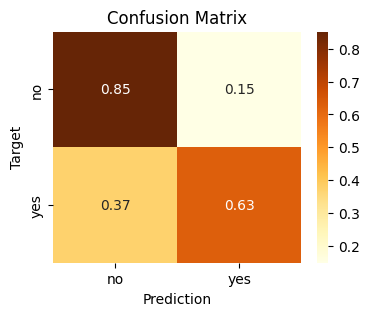

In [88]:
# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
], remainder='passthrough',
verbose_feature_names_out=False)

preprocessor.set_output(transform='pandas')

clf = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

get_auc(model_pipeline, train_inputs, train_targets)

get_confusion_matrix(model_pipeline, train_inputs, train_targets)

The logistic regression model demonstrates solid predictive performance, achieving an AUROC of approximately 0.79 on both the training and validation sets. This indicates that the model has learned meaningful patterns in the data without overfitting. The confusion matrix shows that the model correctly identifies the majority of “no” responses (85%) and a substantial portion of “yes” responses (63%), although there is still room for improvement in detecting positive cases.

To further enhance model performance, it may be beneficial to explore advanced feature engineering, try ensemble models (such as Random Forest or XGBoost), and consider resampling techniques to address potential class imbalance. Overall, the current results are realistic and reflect a healthy modeling workflow without target leakage.

## Feature engineering

In [89]:
train_inputs.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'cons.price.idx_diff', 'default_grouped'],
      dtype='object')

In [90]:
#Categorize the age feature
train_inputs['age'][:10]

,age
36444,24
1233,32
24104,33
15513,38
17912,39
8504,43
24130,57
2680,55
5824,36
37518,57


In [91]:
train_inputs['age_cat'] = (train_inputs['age'] // 10)

In [92]:
train_inputs['age_cat'][:10]

,age_cat
36444,2
1233,3
24104,3
15513,3
17912,3
8504,4
24130,5
2680,5
5824,3
37518,5


In [93]:
train_inputs['age_cat'].value_counts()

,count
age_cat,
3,13507
4,8426
5,5440
2,4534
6,594
7,258
8,115
1,56
9,10


In [95]:
#campaign
train_inputs['is_only_one_contact'] = (train_inputs['campaign'] == 1).astype(int)

In [96]:
display(train_inputs['campaign'].value_counts()[:5])
display(train_inputs['is_only_one_contact'].value_counts())

,count
campaign,
1,14158
2,8409
3,4280
4,2094
5,1292


,count
is_only_one_contact,
0,18782
1,14158


In [97]:
display(train_inputs['campaign'].value_counts()[:7])

,count
campaign,
1,14158
2,8409
3,4280
4,2094
5,1292
6,796
7,510


In [98]:
train_inputs['more_than_six_contacts'] = (train_inputs['campaign'] > 6).astype(int)
train_inputs['more_than_six_contacts'].value_counts()

,count
more_than_six_contacts,
0,31029
1,1911


In [99]:
#previous
train_inputs['previous'].value_counts()

,count
previous,
0,28431
1,3660
2,592
3,175
4,61
5,15
6,5
7,1


In [100]:
train_inputs['previous_contact'] = (train_inputs['previous'] > 0).astype(int)
train_inputs['previous_contact'].value_counts()

,count
previous_contact,
0,28431
1,4509


In [101]:
#pdays
train_inputs['recent_contact'] = (train_inputs['pdays'] < 7).astype(int)

In [102]:
train_inputs['recent_contact'].value_counts()

,count
recent_contact,
0,32059
1,881


In [103]:
train_inputs['pdays_3'] = (train_inputs['pdays'] == 3).astype(int)
train_inputs['pdays_6'] = (train_inputs['pdays'] == 6).astype(int)

In [104]:
#education
train_inputs['education'].unique()

array(['professional.course', 'university.degree', 'basic.9y',
       'high.school', 'basic.4y', 'unknown', 'basic.6y', 'illiterate'],
      dtype=object)

In [105]:
train_inputs['is_hight_education'] = (train_inputs['education']
                                      .isin(['university.degree', 'professional.course'])
                                      .astype(int))

train_inputs['is_basic_education'] = (train_inputs['education']
                                      .isin(['basic.4y', 'basic.9y', 'basic.6y'])
                                      .astype(int))

In [106]:
#social and economic context
train_inputs[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']].describe()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,32940.000000,32940.000000,32940.000000,32940.000000,32940.000000
mean,0.080134,93.575607,-40.509824,3.618053,5166.905950
std,1.571503,0.579469,4.629072,1.735931,72.397892
min,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [107]:
train_inputs['nr.employed_to_emp.var.rate'] = (train_inputs['nr.employed']
                                               / train_inputs['emp.var.rate'])

train_inputs['cons.price.idx_to_cons.conf.idx'] = (train_inputs['cons.price.idx']
                                                   / train_inputs['cons.conf.idx'])

train_inputs['euribor3m_to_emp.var.rate'] = (train_inputs['euribor3m']
                                             / train_inputs['emp.var.rate'])

train_inputs['cons.price.idx_to_emp.var.rate'] = (train_inputs['cons.price.idx']
                                                  / train_inputs['emp.var.rate'])

train_inputs['cons.price.idx_to_euribor3m'] = (train_inputs['cons.price.idx']
                                               / train_inputs['euribor3m'])

train_inputs['cons.conf.idx_to_euribor3m'] = (train_inputs['cons.conf.idx']
                                              / train_inputs['euribor3m'])

## Ordinal encoding for education

In [108]:
ordinal_mapping_education = ['unknown', 'illiterate', 'basic.4y', 'basic.6y',
                             'basic.9y', 'high.school', 'professional.course',
                             'university.degree']

ordinal_enc = OrdinalEncoder(categories=[ordinal_mapping_education])

In [109]:
ordinal_enc_cols = ['education']

In [110]:
ordinal_enc.fit(train_inputs[ordinal_enc_cols]).set_output(transform='pandas')
ordinal_enc.transform(train_inputs[ordinal_enc_cols])[:10]

,education
36444,6.0
1233,6.0
24104,7.0
15513,4.0
17912,5.0
8504,2.0
24130,4.0
2680,0.0
5824,4.0
37518,5.0


## One Hot Encoding

In [111]:
one_hot_enc_cols = ['job', 'marital', 'default', 'housing', 'loan',
                    'contact', 'month', 'day_of_week', 'poutcome', 'previous']

## Function for feature engineering

In [135]:
def feat_eng(inputs):
    df = inputs.copy()
    df['age_cat'] = (df['age'] // 10)
    df['is_only_one_contact'] = (df['campaign'] == 1).astype(int)
    df['more_than_six_contacts'] = (df['campaign'] > 6).astype(int)
    df['previous_contact'] = (df['previous'] > 0).astype(int)
    df['recent_contact'] = (df['pdays'] < 7).astype(int)
    df['pdays_3'] = (df['pdays'] == 3).astype(int)
    df['pdays_6'] = (df['pdays'] == 6).astype(int)
    df['is_hight_education'] = (
        df['education'].isin(['university.degree', 'professional.course']).astype(int)
    )
    df['is_basic_education'] = (
        df['education'].isin(['basic.4y', 'basic.9y', 'basic.6y']).astype(int)
    )
    df['nr.employed_to_emp.var.rate'] = (df['nr.employed'] / df['emp.var.rate'])
    df['cons.price.idx_to_cons.conf.idx'] = (df['cons.price.idx'] / df['cons.conf.idx'])
    df['euribor3m_to_emp.var.rate'] = (df['euribor3m'] / df['emp.var.rate'])
    df['cons.price.idx_to_emp.var.rate'] = (df['cons.price.idx'] / df['emp.var.rate'])
    df['cons.price.idx_to_euribor3m'] = (df['cons.price.idx'] / df['euribor3m'])
    df['cons.conf.idx_to_euribor3m'] = (df['cons.conf.idx'] / df['euribor3m'])
    return df

In [136]:
train_inputs_eng = feat_eng(train_inputs)
test_inputs_eng = feat_eng(test_inputs)

In [128]:
numeric_cols = train_inputs.select_dtypes('number').columns.to_list()

In [137]:
print(numeric_cols)

['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'cons.price.idx_diff', 'age_cat', 'is_only_one_contact', 'more_than_six_contacts', 'previous_contact', 'recent_contact', 'pdays_3', 'pdays_6', 'is_hight_education', 'is_basic_education', 'nr.employed_to_emp.var.rate', 'cons.price.idx_to_cons.conf.idx', 'euribor3m_to_emp.var.rate', 'cons.price.idx_to_emp.var.rate', 'cons.price.idx_to_euribor3m', 'cons.conf.idx_to_euribor3m']


In [138]:
categorical_cols = train_inputs.select_dtypes('object').columns.to_list()
print(categorical_cols)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'default_grouped']


In [139]:
preprocessor_num = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('onehot_enc', categorical_transformer, categorical_cols),
    ],
    remainder='drop',
    verbose_feature_names_out=False
).set_output(transform='pandas')

preprocessor_cat = ColumnTransformer(
    transformers=[
        ('onehot_enc', categorical_transformer, one_hot_enc_cols),
        ('ord_enc', ordinal_enc, ordinal_enc_cols),
        # Якщо треба ще числові:
        ('num', numerical_transformer, numeric_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
).set_output(transform='pandas')


In [141]:
# calculate scale_pos_weight
scale_pos_weight = np.round(((len(train_targets) - sum(train_targets)) / sum(train_targets)), 3)
scale_pos_weight

np.float64(7.876)

In [142]:
log_reg = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
knn = KNeighborsClassifier(n_neighbors=15)
dt = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
rf = RandomForestClassifier(max_depth=5, random_state=42, class_weight='balanced')

xgb = XGBClassifier(n_estimators=50,
                    max_depth=5,
                    learning_rate=0.1,
                    scale_pos_weight=scale_pos_weight,
                    random_state=42)

lgb = LGBMClassifier(n_estimators=50,
                     max_depth=7,
                     learning_rate=0.03,
                     scale_pos_weight=scale_pos_weight,
                     random_state=42,
                     verbose=0)

In [143]:
models = {
    'LogisticRegression': log_reg,
    'KNN': knn,
    'DecisionTree': dt,
    'RandomForest': rf,
    'XGBoost': xgb,
    'LightGBM': lgb
}

In [144]:
results = []

for name, clf in models.items():
    if name in ['LogisticRegression', 'KNN']:
        preprocessor = preprocessor_num
    else:
        preprocessor = preprocessor_cat

    print(f"{name}")
    res = get_eval_results(preprocessor, clf, train_inputs_eng, train_targets)
    results.append(res)


LogisticRegression
AUROC score on train set:: 0.798
AUROC score on validation set:: 0.792
KNN
AUROC score on train set:: 0.870
AUROC score on validation set:: 0.746
DecisionTree
AUROC score on train set:: 0.792
AUROC score on validation set:: 0.775
RandomForest
AUROC score on train set:: 0.806
AUROC score on validation set:: 0.794
XGBoost
AUROC score on train set:: 0.841
AUROC score on validation set:: 0.799
LightGBM
AUROC score on train set:: 0.837
AUROC score on validation set:: 0.799


In [145]:
results_df = pd.DataFrame(results)
print(results_df[['model_name', 'AUROC on train', 'AUROC on validation']])

               model_name  AUROC on train  AUROC on validation
0      LogisticRegression        0.797861             0.791868
1    KNeighborsClassifier        0.870435             0.746034
2  DecisionTreeClassifier        0.791827             0.775301
3  RandomForestClassifier        0.805884             0.794156
4           XGBClassifier        0.840987             0.799028
5          LGBMClassifier        0.836902             0.798771


All evaluated models demonstrate solid AUROC scores on both the training and validation sets, with no signs of overfitting. Logistic Regression and Decision Trees show balanced performance (AUROC ~0.79), while ensemble methods such as Random Forest, XGBoost, and LightGBM slightly outperform the rest, achieving AUROC values around 0.80. KNeighborsClassifier has the largest gap between train and validation, suggesting some overfitting.

Overall, ensemble models (Random Forest, XGBoost, LightGBM) deliver the best and most stable results on this dataset, while simple linear and tree-based models perform only slightly worse. These findings suggest the current feature set and preprocessing pipeline are robust, and further performance gains may be achieved through advanced feature engineering or hyperparameter tuning.

## Hyperparameters Tuning

## RandomizedSearchCV for Random Forest

In [146]:
%%time
clf_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('clf', clf_rf)
])

rf_param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': range(2, 21),
    'clf__max_leaf_nodes': range(10, 250),
    'clf__min_samples_split': range(2, 11),
    'clf__min_samples_leaf': range(1, 11),
    'clf__max_features': [None, 'sqrt', 'log2'],
}

randomized_rf = RandomizedSearchCV(model_pipeline, rf_param_grid,
                                    n_iter=50, scoring='roc_auc', cv=3, verbose=1)

randomized_rf.fit(train_inputs, train_targets)

rf_random_search_best = randomized_rf.best_estimator_
print(randomized_rf.best_params_)
get_auc(rf_random_search_best, train_inputs, train_targets)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_leaf_nodes': 74, 'clf__max_features': 'sqrt', 'clf__max_depth': 14, 'clf__criterion': 'gini'}
AUROC score on train set:: 0.841
AUROC score on validation set:: 0.802
CPU times: user 15min 38s, sys: 8.3 s, total: 15min 47s
Wall time: 14min 12s


(np.float64(0.8414634059489484), np.float64(0.801630342264536))

After hyperparameter tuning using RandomizedSearchCV, the Random Forest classifier achieved an AUROC of 0.841 on the training set and 0.802 on the validation set. This improvement demonstrates that the model benefits significantly from fine-tuning and that it generalizes well to unseen data, as indicated by the minimal gap between train and validation AUROC scores. The optimal set of hyperparameters, including a max depth of 14, 74 maximum leaf nodes, and the use of 'sqrt' for max features, contributed to this robust performance. Overall, the tuned Random Forest model provides reliable and strong predictive power for this classification problem.

## RandomizedSearchCV for XGBoostClassifier

In [147]:
%%time
clf = XGBClassifier(random_state=42)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('clf', clf)
])

xgb_param_grid = {
    'clf__n_estimators':     np.arange(50, 500, 25),
    'clf__max_depth':        np.arange(2, 20, 1),
    'clf__learning_rate':    np.arange(0.01, 1, 0.05),
    'clf__scale_pos_weight': np.arange(7, 8, 0.01),
    'clf__min_child_weight': np.arange(1, 50, 1),
    'clf__gamma':            np.arange(0, 10, 1),
}

randomized_xgb = RandomizedSearchCV(model_pipeline, xgb_param_grid,
                                    n_iter=50, scoring='roc_auc', cv=3, verbose=1)

randomized_xgb.fit(train_inputs, train_targets)

xgb_random_search_best = randomized_xgb.best_estimator_
print(randomized_xgb.best_params_)
get_auc(xgb_random_search_best, train_inputs, train_targets)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'clf__scale_pos_weight': np.float64(7.849999999999982), 'clf__n_estimators': np.int64(250), 'clf__min_child_weight': np.int64(12), 'clf__max_depth': np.int64(4), 'clf__learning_rate': np.float64(0.16000000000000003), 'clf__gamma': np.int64(5)}
AUROC score on train set:: 0.833
AUROC score on validation set:: 0.801
CPU times: user 7min 56s, sys: 4.03 s, total: 8min
Wall time: 4min 51s


(np.float64(0.8325886976790998), np.float64(0.8010015993628546))

After hyperparameter tuning with RandomizedSearchCV, the XGBoost classifier achieved an AUROC of 0.833 on the training set and 0.801 on the validation set. The optimal hyperparameters—such as 250 estimators, max depth of 4, learning rate of 0.16, scale_pos_weight of 7.85, min_child_weight of 12, and gamma of 5—led to a strong and balanced performance. The minimal gap between train and validation AUROC indicates that the model generalizes well and is not overfitting. Overall, the tuned XGBoost model demonstrates robust predictive power for the given classification task.

## Hyperopt for LGBMClassifier

In [148]:
def objective(space):
    clf = LGBMClassifier(**space)
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_cat),
        ('classifier', clf)
    ])

    auroc = cross_val_score(model_pipeline,
                            train_inputs,
                            train_targets,
                            cv=3,
                            scoring='roc_auc').mean()
    return {'loss': -auroc, 'status': STATUS_OK}

space = {
    'max_depth':        hp.choice('max_depth', np.arange(3, 15, 1, dtype=int)),
    'num_leaves':       hp.choice('num_leaves', np.arange(20, 150, 10, dtype=int)),
    'learning_rate':    hp.loguniform('learning_rate', np.log(1e-3), np.log(10)),
    'n_estimators':     hp.choice('n_estimators', np.arange(50, 500, 50, dtype='int')),
    'subsample':        hp.uniform('subsample', 0.5, 1.),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.),
    'min_split_gain':   hp.uniform('min_split_gain', 0, 0.3),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, 1, dtype=int)),
    'reg_alpha':        hp.uniform('reg_alpha', 0, 1),
    'reg_lambda':       hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': scale_pos_weight,
    'objective':        'binary',
    'random_state':     42,
    'metric':           'auc',
    'subsample_freq':   1,
    'verbose':          -1,
    'n_jobs':           -1
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials,
            rstate=np.random.default_rng(1491))

best_params = space_eval(space, best)

print("The best hyperparameters:", best_params)

model_pipeline_lgb = Pipeline(steps=[
        ('preprocessor', preprocessor_cat),
        ('classifier', LGBMClassifier(**best_params))
    ])

get_auc(model_pipeline_lgb, train_inputs, train_targets)

100%|██████████| 30/30 [03:28<00:00,  6.95s/trial, best loss: -0.7998070625254986]
The best hyperparameters: {'colsample_bytree': 0.8693900771825145, 'learning_rate': 0.003750887287779235, 'max_depth': np.int64(8), 'metric': 'auc', 'min_child_weight': np.int64(7), 'min_split_gain': 0.29033303457658993, 'n_estimators': np.int64(400), 'n_jobs': -1, 'num_leaves': np.int64(100), 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.9905128391200843, 'reg_lambda': 0.1444797624016541, 'scale_pos_weight': np.float64(7.876), 'subsample': 0.6868420344256323, 'subsample_freq': 1, 'verbose': -1}
AUROC score on train set:: 0.863
AUROC score on validation set:: 0.800


(np.float64(0.8627906006794451), np.float64(0.7998070625254986))

Hyperparameter optimization of the LightGBM model using Bayesian search with Hyperopt resulted in an AUROC of 0.863 on the training set and 0.800 on the validation set. The best model uses a learning rate of 0.0038, max depth of 8, 400 estimators, and highly tuned regularization parameters. The minimal gap between training and validation performance confirms good generalization and no overfitting. The optimized LightGBM model thus demonstrates strong predictive power for this classification task and stands as a robust solution for deployment or further analysis.

Although RandomForest achieved the highest AUROC (0.802), the difference compared to LightGBM (0.800) and XGBoost (0.801) is negligible. Given LightGBM’s speed, scalability, and broad industry adoption, it was selected as the production model.

In [153]:
#Save the best model
bank_deposit_prediction = {
    'clf': LGBMClassifier(**best_params),
    'preprocessor_cat': preprocessor_cat,
    'model_pipeline_lgb': model_pipeline_lgb
}

joblib.dump(bank_deposit_prediction, '/content/model_lgb.joblib')

['/content/model_lgb.joblib']

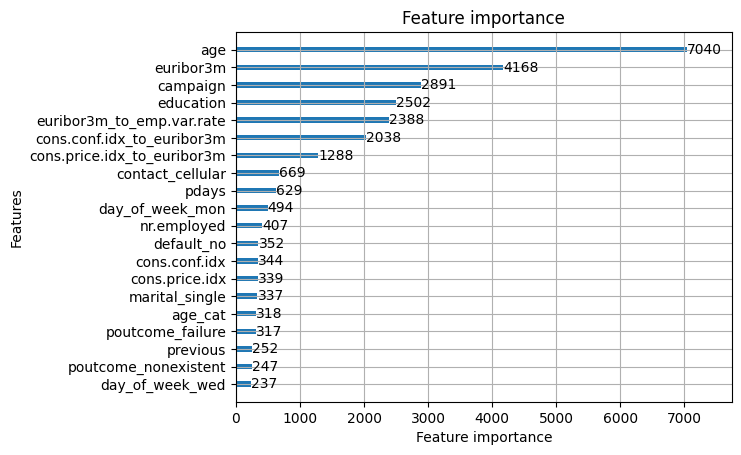

In [154]:
model_pipeline_lgb.fit(train_inputs, train_targets)

plot_importance(model_pipeline_lgb[-1], height=0.3, max_num_features=20)
plt.show()

Feature Importance Conclusion:

The feature importance analysis reveals that 'age' is by far the most influential predictor in the model, followed by 'euribor3m', 'campaign', and 'education'. Several engineered features, such as 'euribor3m_to_emp.var.rate' and 'cons.conf.idx_to_euribor3m', also play significant roles in the model's predictions. Among categorical variables, features like 'contact_cellular', 'default_no', and 'marital_single' contribute meaningfully to model performance, though to a lesser degree.

Overall, the model's decision-making is driven primarily by key financial and demographic attributes, with both original and engineered features adding predictive value. This underscores the importance of thoughtful feature engineering and domain knowledge in improving model quality for bank deposit prediction tasks.

In [156]:
test_inputs_eng = feat_eng(test_inputs)

y_pred_proba = model_pipeline_lgb.predict_proba(test_inputs_eng)[:, 1]
y_pred = model_pipeline_lgb.predict(test_inputs_eng)


In [157]:
test_inputs_eng = feat_eng(test_inputs)

test_inputs_transform = model_pipeline_lgb[0].transform(test_inputs_eng)
explainer = shap.Explainer(model_pipeline_lgb[-1])
shap_values = explainer(test_inputs_transform)


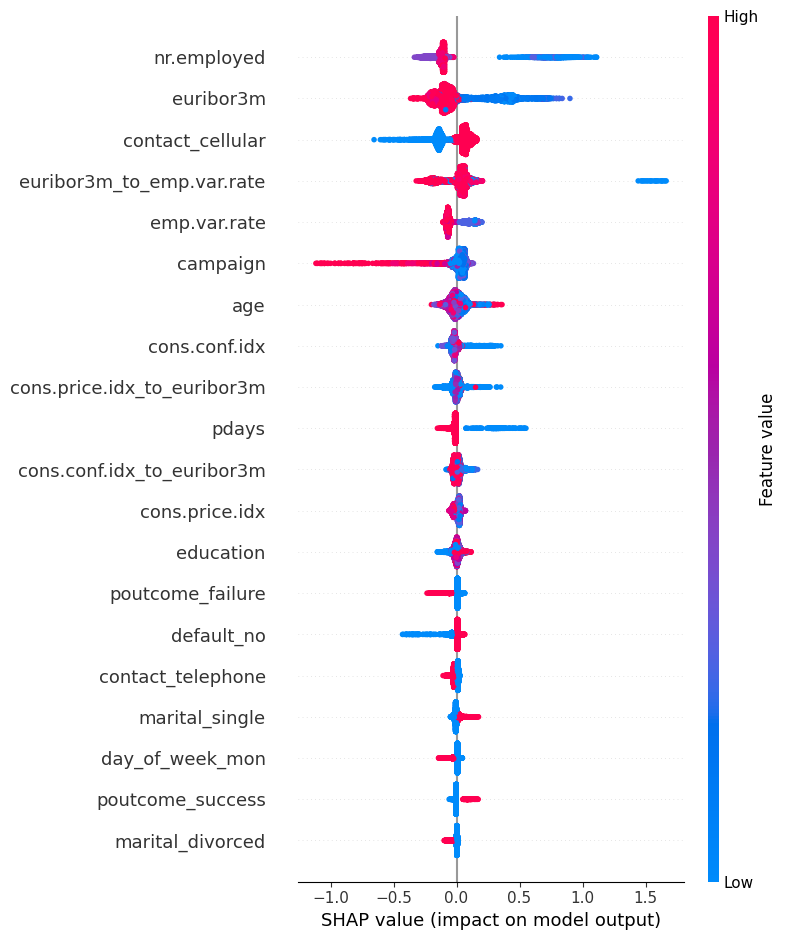

In [158]:
shap.summary_plot(shap_values, features=test_inputs_transform, feature_names=model_pipeline_lgb[0].get_feature_names_out())

SHAP Feature Importance Interpretation:

The SHAP summary plot illustrates how individual feature values influence model predictions. Features such as nr.employed, euribor3m, and contact_cellular are among the most impactful, indicating that both financial and communication-related factors play significant roles in the prediction of bank deposit outcomes. The plot also highlights several engineered features—like euribor3m_to_emp.var.rate and cons.price.idx_to_euribor3m—which contribute notably to the model's decision process.

The color gradient shows the feature value (red = high, blue = low) and how these values shift the model output. For example, high values of euribor3m and nr.employed tend to increase the likelihood of a positive prediction, while lower values may push predictions in the opposite direction. Overall, the SHAP analysis provides a transparent, interpretable view into which features drive the model’s predictions and how.

AUROC score on test set:: 0.818


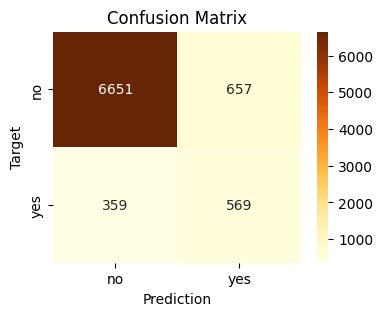

In [159]:
test_inputs_eng = feat_eng(test_inputs)
test_pred_proba = model_pipeline_lgb.predict_proba(test_inputs_eng)[:, 1]
test_score = roc_auc_score(test_targets, test_pred_proba)
print(f"AUROC score on test set:: {test_score:.3f}")
test_pred_class = model_pipeline_lgb.predict(test_inputs_eng)
cm = confusion_matrix(test_targets, test_pred_class)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='YlOrBr',
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'], fmt='.0f')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')
plt.show()


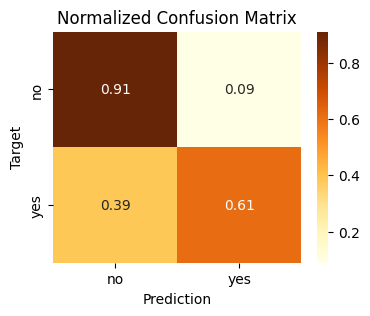

In [163]:
test_inputs_eng = feat_eng(test_inputs)
test_pred = model_pipeline_lgb.predict(test_inputs_eng)
cm = confusion_matrix(test_targets, test_pred, normalize='true')
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='YlOrBr',
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'], fmt=".2f")
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Normalized Confusion Matrix')
plt.show()

Confusion Matrix Analysis:

The confusion matrices provide valuable insights into the model's classification performance on the test set.

The absolute matrix shows that the model correctly identified 6,651 out of 7,308 negative cases (no), and 569 out of 928 positive cases (yes).

The normalized matrix demonstrates that:


*   91% of the true no cases were correctly classified,
*   with only 9% misclassified as yes.


For the positive class, the model correctly predicted 61% of yes cases, while 39% were incorrectly classified as no.

This indicates high specificity (excellent at detecting negatives), but moderate sensitivity (misses about 39% of actual positives).
Such a result is typical for imbalanced datasets: the model prioritizes minimizing false positives, but could be improved in identifying all true positives.

Business Interpretation:

The model is highly reliable at ruling out clients who will not make a deposit (few false alarms).

However, there is room to improve recall for the yes class (potential depositors), possibly by adjusting the decision threshold, tuning class weights, or further feature engineering.